<a href="https://colab.research.google.com/github/barakhoffer/sky130_xyce_reram/blob/main/Sky130_ReRAM_Xyce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install

##Install PDK

In [1]:
PDK_HASH = 'fa87f8f4bbcc7255b6f0c0fb506960f531ae2392'
PDK_ROOT = '/root/.volare/volare/sky130/versions'
PDKPATH = f'{PDK_ROOT}/sky130B'
%env PDK_ROOT={PDK_ROOT}
%env PDKPATH={PDKPATH}
!pip install --upgrade --no-cache-dir volare
!volare enable --pdk sky130 {PDK_HASH}

env: PDK_ROOT=/root/.volare/volare/sky130/versions
env: PDKPATH=/root/.volare/volare/sky130/versions/sky130B
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 91 kB 7.4 MB/s 
     |████████████████████████████████| 214 kB 39.3 MB/s 
     |████████████████████████████████| 62 kB 21.0 MB/s 
     |████████████████████████████████| 96 kB 34.2 MB/s 
     |████████████████████████████████| 636 kB 9.6 MB/s 
     |████████████████████████████████| 51 kB 36.5 MB/s 
  Created wheel for click-default-group: filename=click_default_group-1.2.2-py3-none-any.whl size=3385 sha256=23960c4e9e09e51ef626fb7ebd20751cc36d2c72ac013bcf57791f77b66121bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-donbbghw/wheels/c8/01/63/03a469931aa81497b07ada86ff8aa1b18847bdbe474f43d82c
Successfully built click-default-group
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
     

## Install Spack and Xyce

In [2]:
import os.path
from google.colab import drive

g_init_cmd = []

def system_w_init(cmd): 
    system_orig(';'.join(g_init_cmd + [cmd])) 

def getoutput_w_init(cmd):
    return getoutput_orig(';'.join(g_init_cmd + [cmd]))

if not 'system_w_init' in str(get_ipython().system):
    system_orig = get_ipython().system
if not 'getoutput_w_init' in str(get_ipython().getoutput):
    getoutput_orig = get_ipython().getoutput

get_ipython().system = system_w_init
get_ipython().getoutput = getoutput_w_init

# Install Spack and Xyce
install_pre = !apt-get install file bc
clone_spacke = !git clone https://github.com/spack/spack ~/.spack/Spack

g_init_cmd.append('source ~/.spack/Spack/share/spack/setup-env.sh')

open('spack_restore.sh', 'w').write("""
#!/bin/sh
if [ -f "$1" ]; then
    spack gpg init
    mkdir -p "$2"
    tar xzvf "$1" -C "$2"
    spack gpg trust "$2/public.key"
    spack mirror add mirror "$2"
    spack buildcache update-index -d "$2"
    spack buildcache keys --install --trust
    for s in $(spack buildcache list | tail -n +2); do
        spack buildcache install "$s"
    done
fi
""")
open('spack_build.sh', 'w').write("""
#!/bin/sh
if [ ! -f "$1" ]; then
    spack gpg init
    mkdir -p "$2"
    spack gpg create Colab colab@colab
    for s in $(spack find --no-groups -L | cut -f 1 -d ' ' ); do
        spack buildcache create -d "$2" -a --only package "/$s"
    done
    spack gpg export "$2/public.key"
    cd "$2"
    mkdir -p "$(dirname "$1")"
    tar czvf "$1" .
fi
""")

!chmod +x ./spack_restore.sh
!chmod +x ./spack_build.sh

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')

!./spack_restore.sh "/content/drive/MyDrive/Colab Notebooks/data/spack_build.tar.gz" /content/colab_cache

xyce_find = !spack find xyce | grep xyce@
if len(xyce_find) == 0 or not ('xyce' in xyce_find[0]):
    !spack install xyce@7.5.0+plugin+mpi

!./spack_build.sh "/content/drive/MyDrive/Colab Notebooks/data/spack_build.tar.gz" /content/colab_cache

g_init_cmd.append('spack load xyce')

./
./build_cache/
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-texinfo-6.5-bh4rou65ww5yaffx3z4v47m2uvt6nfwz.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-libedit-3.1-20210216-6pzlk2kvqkamuqk4fqzn3q5iuxlmaynt.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-automake-1.16.5-yojw6lwxzhjdisj2fe2kbynzkqoygpu5.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-openblas-0.3.21-lu5ppfpiga2pj6j3sfptkl6ufisfgfae.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-ncurses-6.3-uci6p6s3mmpwncx6gmnfebq6suyt4rqm.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-perl-path-tiny-0.108-u6vam6xsqg754huigx2bcwmqhsinhzmz.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-xyce-7.5.0-rgid6ys2ej4c4aeqwb5bqut6wfpy5lbt.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-gdbm-1.19-gir72hmmmhafk4al7jithi2zqwfq4dah.spec.json.sig
./build_cache/linux-ubuntu18.04-broadwell-gcc-7.5.0-krb5-1.19.3-fqhaukf

## Install ReRAM for Xyce

In [3]:
!git clone https://github.com/barakhoffer/sky130_xyce_reram
!./sky130_xyce_reram/install.sh

Cloning into 'sky130_xyce_reram'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 64 (delta 26), reused 50 (delta 16), pack-reused 0
Unpacking objects: 100% (64/64), done.
Cloning into 'sky130_fd_pr_reram'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 199 (delta 41), reused 34 (delta 34), pack-reused 141
Receiving objects: 100% (199/199), 3.56 MiB | 11.37 MiB/s, done.
Resolving deltas: 100% (88/88), done.
patching file /content/sky130_xyce_reram/xyce/sky130_fd_pr_reram__reram_module.va
buildxyceplugin is building a plugin from the Verilog-A files:
/content/sky130_xyce_reram/xyce/sky130_fd_pr_reram__reram_module.va
The plugin name will be sky130_fd_pr_reram__reram_module.so
Generating C++ for Verilog-A input file '/content/sky130_xyce_reram/xyce/sky130_fd_pr_reram__reram_module.va'.

##Install Spicy

In [4]:
!pip install spyci

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Run ReRAM example

In [5]:
!cd $PDKPATH/libs.tech/xyce && XyceLP.sh reram_example.spice -a -r /content/reram_example.raw


*****
***** Welcome to the Xyce(TM) Parallel Electronic Simulator
*****
***** This is version Xyce Release 7.5.0-opensource
***** Date: Mon Oct 24 17:01:53 UTC 2022


***** Executing netlist reram_example.spice

***** Reading and parsing netlist...
Netlist warning: No print specified
***** Setting up topology...

***** Device Count Summary ...
       SKY130_FD_PR_RERAM__RERAM_MODULE level 1 (ADMS sky130_fd_pr_reram__reram_module) 1
       V level 1 (Independent Voltage Source)                                           1
       ----------------------------------------------------------------------------------
       Total Devices                                                                    2
***** Setting up matrix structure...
***** Number of Unknowns = 3
***** Initializing...

***** Beginning DC Operating Point Calculation...

***** Beginning Transient Calculation...

***** Percent complete: 1.03272 %
***** Current system time: Mon Oct 24 17:01:53 2022
***** Estimated time to c

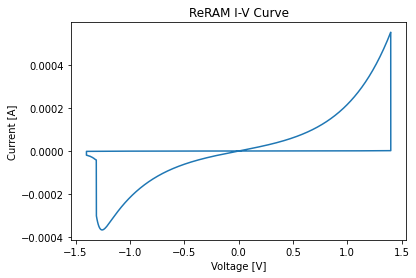

In [6]:
from spyci import spyci
import matplotlib.pyplot as plt

data = spyci.load_raw("reram_example.raw")
plt.plot(data['values']['TE'].real, -data['values']['V1#branch'].real)
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.title("ReRAM I-V Curve")
plt.show()